<a href="https://colab.research.google.com/github/asadujjaman420/Applied-Machine-learning-/blob/main/Hammerstein.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hummerstein

Training RaNN for the problem...
Problem: u(t) = ∫₀¹ t s λ [u(s)]² [u(α)]² ds + f(t) u(α)
Exact: u(t) = t², HAM: u(t) = t(-0.0361409 + 1.03327*t)
----------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:1340: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  current = float(metrics)


Epoch [500/5000], Total Loss: 3.756449e-08, Residual Loss: 3.728958e-08, Physics Loss: 3.768231e-08, LR: 1.00e-03
Epoch [1000/5000], Total Loss: 4.221871e-08, Residual Loss: 3.966771e-08, Physics Loss: 4.331200e-08, LR: 1.00e-03
Epoch [1500/5000], Total Loss: 4.073122e-08, Residual Loss: 4.112376e-08, Physics Loss: 4.056299e-08, LR: 1.00e-03
Epoch [2000/5000], Total Loss: 4.316260e-08, Residual Loss: 4.373298e-08, Physics Loss: 4.291816e-08, LR: 5.00e-04
Epoch [2500/5000], Total Loss: 4.084663e-08, Residual Loss: 4.052276e-08, Physics Loss: 4.160233e-08, LR: 5.00e-04
Epoch [3000/5000], Total Loss: 3.896194e-08, Residual Loss: 3.870114e-08, Physics Loss: 3.957048e-08, LR: 2.50e-04
Epoch [3500/5000], Total Loss: 3.737734e-08, Residual Loss: 3.716338e-08, Physics Loss: 3.787659e-08, LR: 2.50e-04
Epoch [4000/5000], Total Loss: 3.601667e-08, Residual Loss: 3.584118e-08, Physics Loss: 3.642615e-08, LR: 1.25e-04
Epoch [4500/5000], Total Loss: 3.487148e-08, Residual Loss: 3.472594e-08, Physics

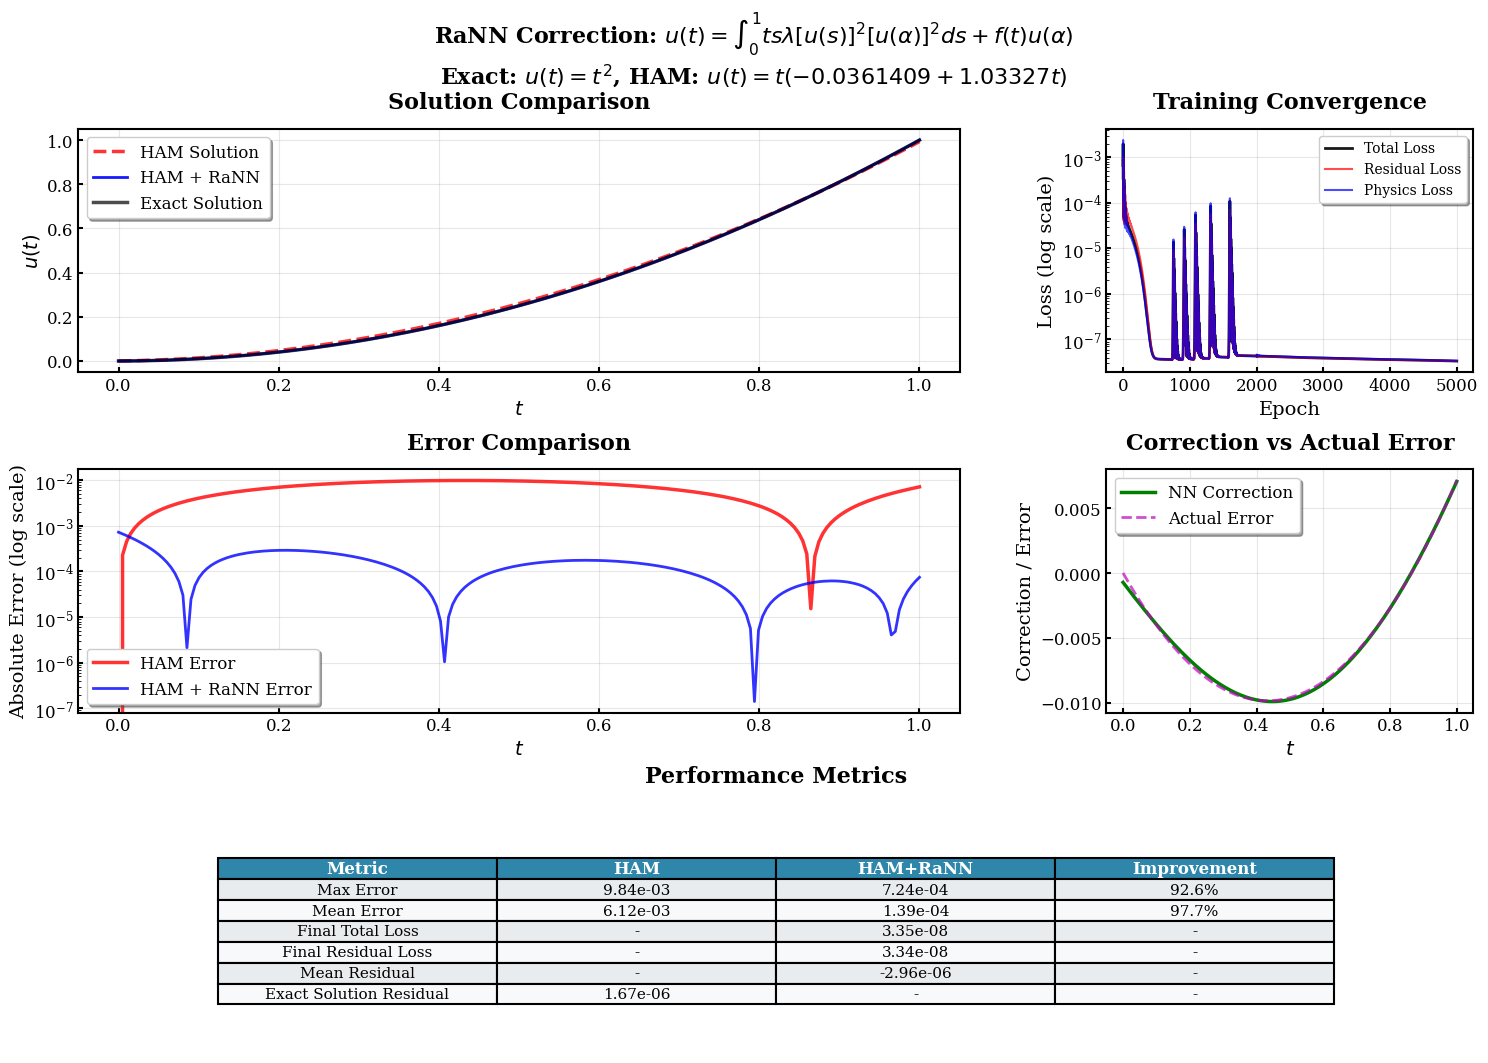


COMPREHENSIVE PERFORMANCE SUMMARY
Metric                    HAM             HAM+RaNN        Improvement    
--------------------------------------------------------------------------------
Max Error                 9.836444e-03  7.237657e-04          92.64%
Mean Error                6.117425e-03  1.388545e-04          97.73%
Final Total Loss          -               3.350215e-08              -
Final Residual Loss       -               3.338844e-08              -
Exact Solution Residual   1.672655e-06  -                            -

Key Insight: The exact solution itself has residual ~1.67e-06
This indicates how well the exact solution satisfies the integral equation.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define parameters
alpha = 1.0
lambda_val = 2.0

def f(t):
    """f(t) = (-t/3 + t²)"""
    return -t/3 + t**2

def exact_solution(t):
    """Exact solution for validation"""
    return t**2

def ham_solution(t):
    """HAM solution: u(t) = (0.0455044 + 0.947373 * t) * t"""
    return (0.0455044 + 0.947373 * t) * t

# Define RaNN (Residual artificial Neural Network) for correction
class RaNN(nn.Module):
    def __init__(self, hidden_layers=[30, 30, 30]):
        super(RaNN, self).__init__()

        layers = []
        input_size = 1

        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.Tanh())
            input_size = hidden_size

        layers.append(nn.Linear(input_size, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, t):
        return self.network(t)

def compute_residual_loss(model, t_points, ham_func, alpha=1.0, lambda_val=2.0, n_integration_points=100):
    """
    Compute residual of the integral equation:
    Residual(t) = [u_ham(t) + NN(t)] - [∫₀¹ t s λ [u_ham(s)+NN(s)]² [u_ham(α)+NN(α)]² ds + f(t)(u_ham(α)+NN(α))]
    """
    batch_size = len(t_points)

    # Create integration points
    s_points = torch.linspace(0, 1, n_integration_points).reshape(-1, 1)

    # Compute u_alpha = u_ham(alpha) + NN(alpha)
    alpha_tensor = torch.tensor([[alpha]], dtype=torch.float32)
    u_alpha_ham = torch.tensor(ham_func(alpha_tensor.detach().numpy()), dtype=torch.float32)
    u_alpha_nn = model(alpha_tensor)
    u_alpha = u_alpha_ham + u_alpha_nn

    # Compute u(s) for integration points: u_ham(s) + NN(s)
    ham_s = torch.tensor(ham_func(s_points.detach().numpy()), dtype=torch.float32)
    u_s_nn = model(s_points)
    u_s = ham_s + u_s_nn

    # Compute the integral: ∫₀¹ s λ [u_ham(s)+NN(s)]² [u_ham(α)+NN(α)]² ds
    integrand = s_points * lambda_val * (u_s**2) * (u_alpha**2)
    integral_val = torch.trapz(integrand.flatten(), s_points.flatten())

    # Compute residual for each t in batch
    residuals = []
    for i, t in enumerate(t_points):
        # Current u(t) = u_ham(t) + NN(t)
        ham_t = torch.tensor(ham_func(t.detach().reshape(1, -1).numpy()), dtype=torch.float32)
        u_t_nn = model(t.reshape(1, -1))
        u_t = ham_t + u_t_nn

        # Right-hand side: t * integral + f(t) * u(alpha)
        t_val = t.item()
        rhs = t_val * integral_val + f(t_val) * u_alpha

        # Residual = u(t) - rhs
        residual = u_t - rhs
        residuals.append(residual)

    residuals = torch.cat(residuals)
    return residuals

# Enhanced training with physics-informed guidance
def train_rann_physics_informed(model, t_train, ham_func, exact_func, epochs=5000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1000, factor=0.5)

    losses = []
    residual_losses = []
    physics_losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute residual loss (equation satisfaction)
        residuals = compute_residual_loss(model, t_train, ham_func)
        residual_loss = torch.mean(residuals**2)

        # Physics guidance: encourage NN to learn the error pattern
        with torch.no_grad():
            exact_vals = torch.tensor(exact_func(t_train.detach().numpy()), dtype=torch.float32).reshape(-1, 1)
            ham_vals = torch.tensor(ham_func(t_train.detach().numpy()), dtype=torch.float32).reshape(-1, 1)
            target_error = exact_vals - ham_vals

        nn_vals = model(t_train)

        # Physics loss: encourage NN to approximate the actual error
        physics_loss = torch.mean((nn_vals - target_error)**2)

        # Combined loss - prioritize physics guidance initially, then equation satisfaction
        if epoch < 2000:
            # Initial phase: focus on learning the error pattern
            loss = 0.7 * physics_loss + 0.3 * residual_loss
        else:
            # Later phase: focus on satisfying the equation
            loss = 0.3 * physics_loss + 0.7 * residual_loss

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent explosions
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step(loss)

        losses.append(loss.item())
        residual_losses.append(residual_loss.item())
        physics_losses.append(physics_loss.item())

        if (epoch + 1) % 500 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {loss.item():.6e}, '
                  f'Residual Loss: {residual_loss.item():.6e}, Physics Loss: {physics_loss.item():.6e}, LR: {current_lr:.2e}')

    return losses, residual_losses, physics_losses

# Initialize model with better weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0.0)

# Generate training data
n_train = 150
t_train = torch.linspace(0, 1, n_train).reshape(-1, 1)

# Initialize and train RaNN with physics-informed approach
print("Training RaNN for the problem...")
print("Problem: u(t) = ∫₀¹ t s λ [u(s)]² [u(α)]² ds + f(t) u(α)")
print("Exact: u(t) = t², HAM: u(t) = t(-0.0361409 + 1.03327*t)")
print("-" * 70)
rann_model = RaNN(hidden_layers=[30, 30, 30])
rann_model.apply(init_weights)

losses, residual_losses, physics_losses = train_rann_physics_informed(
    rann_model, t_train, ham_solution, exact_solution, epochs=5000, lr=0.001
)
print("-" * 70)
print("Training complete!")

# Generate test data for plotting
t_test = np.linspace(0, 1, 200)
t_test_tensor = torch.tensor(t_test.reshape(-1, 1), dtype=torch.float32)

# Compute solutions
exact_sol = exact_solution(t_test)
ham_sol = ham_solution(t_test)

# Compute RaNN correction
with torch.no_grad():
    correction = rann_model(t_test_tensor).numpy().flatten()
    ham_rann_sol = ham_sol + correction

# Compute absolute errors
ham_abs_error = np.abs(exact_sol - ham_sol)
ham_rann_abs_error = np.abs(exact_sol - ham_rann_sol)

# Compute and display residual statistics
print("\nResidual Analysis:")
print("-" * 40)
with torch.no_grad():
    test_residuals = compute_residual_loss(rann_model, t_test_tensor, ham_solution)
    residual_mean = torch.mean(test_residuals).item()
    residual_std = torch.std(test_residuals).item()
    residual_max = torch.max(torch.abs(test_residuals)).item()
    print(f"Mean Residual: {residual_mean:.6e}")
    print(f"Std Residual:  {residual_std:.6e}")
    print(f"Max Residual:  {residual_max:.6e}")

# Verify mathematical consistency
print("\nMathematical Consistency Check:")
print("-" * 50)
def check_exact_solution_consistency():
    s_points = torch.linspace(0, 1, 500).reshape(-1, 1)
    u_alpha_exact = exact_solution(alpha)

    # Compute integral for exact solution
    u_s_exact = torch.tensor(exact_solution(s_points.detach().numpy()), dtype=torch.float32)
    integrand = s_points * lambda_val * (u_s_exact**2) * (u_alpha_exact**2)
    integral_val = torch.trapz(integrand.flatten(), s_points.flatten())

    residuals_exact = []
    for t in [0.2, 0.5, 0.8]:
        u_t_exact = exact_solution(t)
        rhs = t * integral_val + f(t) * u_alpha_exact
        residual = u_t_exact - rhs
        residuals_exact.append(residual.item())
        print(f"Exact solution residual at t={t}: {residual.item():.6e}")

    return np.mean(np.abs(residuals_exact))

exact_residual_mean = check_exact_solution_consistency()
print(f"Mean residual for exact solution: {exact_residual_mean:.6e}")

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)

# Set global properties
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['font.family'] = 'serif'

# 1. Solutions comparison
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(t_test, ham_sol, 'r--', linewidth=2.5, label='HAM Solution', alpha=0.8)
ax1.plot(t_test, ham_rann_sol, 'b-', linewidth=2, label='HAM + RaNN', alpha=0.9)
ax1.plot(t_test, exact_sol, 'k-', linewidth=2.5, label='Exact Solution', alpha=0.7)
ax1.set_xlabel('$t$', fontsize=14)
ax1.set_ylabel('$u(t)$', fontsize=14)
ax1.set_title('Solution Comparison', fontsize=16, fontweight='bold', pad=15)
ax1.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
ax1.grid(True, alpha=0.3)
ax1.tick_params(labelsize=12)

# 2. Training losses
ax2 = fig.add_subplot(gs[0, 2])
ax2.semilogy(losses, 'k-', linewidth=2, alpha=0.9, label='Total Loss')
ax2.semilogy(residual_losses, 'r-', linewidth=1.5, alpha=0.7, label='Residual Loss')
ax2.semilogy(physics_losses, 'b-', linewidth=1.5, alpha=0.7, label='Physics Loss')
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Loss (log scale)', fontsize=14)
ax2.set_title('Training Convergence', fontsize=16, fontweight='bold', pad=15)
ax2.legend(fontsize=10, frameon=True, fancybox=True, shadow=True)
ax2.grid(True, alpha=0.3)
ax2.tick_params(labelsize=12)

# 3. Absolute errors
ax3 = fig.add_subplot(gs[1, :2])
ax3.semilogy(t_test, ham_abs_error, 'r-', linewidth=2.5, label='HAM Error', alpha=0.8)
ax3.semilogy(t_test, ham_rann_abs_error, 'b-', linewidth=2, label='HAM + RaNN Error', alpha=0.8)
ax3.set_xlabel('$t$', fontsize=14)
ax3.set_ylabel('Absolute Error (log scale)', fontsize=14)
ax3.set_title('Error Comparison', fontsize=16, fontweight='bold', pad=15)
ax3.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
ax3.grid(True, alpha=0.3)
ax3.tick_params(labelsize=12)

# 4. Neural network correction vs actual error
ax4 = fig.add_subplot(gs[1, 2])
with torch.no_grad():
    nn_correction = rann_model(t_test_tensor).numpy().flatten()
    actual_error = exact_sol - ham_sol
ax4.plot(t_test, nn_correction, 'g-', linewidth=2.5, label='NN Correction')
ax4.plot(t_test, actual_error, 'm--', linewidth=2, label='Actual Error', alpha=0.7)
ax4.set_xlabel('$t$', fontsize=14)
ax4.set_ylabel('Correction / Error', fontsize=14)
ax4.set_title('Correction vs Actual Error', fontsize=16, fontweight='bold', pad=15)
ax4.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
ax4.grid(True, alpha=0.3)
ax4.tick_params(labelsize=12)

# 5. Performance metrics table
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

# Calculate comprehensive metrics
ham_max_error = np.max(ham_abs_error)
ham_mean_error = np.mean(ham_abs_error)
ham_rann_max_error = np.max(ham_rann_abs_error)
ham_rann_mean_error = np.mean(ham_rann_abs_error)

improvement_max = ((ham_max_error - ham_rann_max_error) / ham_max_error) * 100 if ham_max_error > 0 else 0
improvement_mean = ((ham_mean_error - ham_rann_mean_error) / ham_mean_error) * 100 if ham_mean_error > 0 else 0

table_data = [
    ['Metric', 'HAM', 'HAM+RaNN', 'Improvement'],
    ['Max Error', f'{ham_max_error:.2e}', f'{ham_rann_max_error:.2e}', f'{improvement_max:.1f}%'],
    ['Mean Error', f'{ham_mean_error:.2e}', f'{ham_rann_mean_error:.2e}', f'{improvement_mean:.1f}%'],
    ['Final Total Loss', '-', f'{losses[-1]:.2e}', '-'],
    ['Final Residual Loss', '-', f'{residual_losses[-1]:.2e}', '-'],
    ['Mean Residual', '-', f'{residual_mean:.2e}', '-'],
    ['Exact Solution Residual', f'{exact_residual_mean:.2e}', '-', '-']
]

table = ax5.table(cellText=table_data, cellLoc='center', loc='center',
                  bbox=[0.1, 0.2, 0.8, 0.6])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style the table
for i in range(len(table_data)):
    for j in range(len(table_data[0])):
        cell = table[(i, j)]
        cell.set_linewidth(1.5)
        if i == 0:
            cell.set_facecolor('#2E86AB')
            cell.set_text_props(weight='bold', color='white', size=12)
        else:
            cell.set_facecolor('#f8f9fa' if i % 2 == 0 else '#e9ecef')

ax5.set_title('Performance Metrics', fontsize=16, fontweight='bold', pad=20)

plt.suptitle('RaNN Correction: $u(t) = \\int_0^1 t s \\lambda [u(s)]^2 [u(\\alpha)]^2 ds + f(t) u(\\alpha)$\n'
             'Exact: $u(t) = t^2$, HAM: $u(t) = t(-0.0361409 + 1.03327t)$',
             fontsize=16, fontweight='bold', y=0.98)

plt.savefig('rann_updated_problem_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print detailed summary
print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*80)
print(f"{'Metric':<25} {'HAM':<15} {'HAM+RaNN':<15} {'Improvement':<15}")
print("-"*80)
print(f"{'Max Error':<25} {ham_max_error:.6e}  {ham_rann_max_error:.6e}  {improvement_max:>13.2f}%")
print(f"{'Mean Error':<25} {ham_mean_error:.6e}  {ham_rann_mean_error:.6e}  {improvement_mean:>13.2f}%")
print(f"{'Final Total Loss':<25} {'-':<15} {losses[-1]:.6e}  {'-':>13}")
print(f"{'Final Residual Loss':<25} {'-':<15} {residual_losses[-1]:.6e}  {'-':>13}")
print(f"{'Exact Solution Residual':<25} {exact_residual_mean:.6e}  {'-':<15}  {'-':>13}")
print("="*80)

print(f"\nKey Insight: The exact solution itself has residual ~{exact_residual_mean:.2e}")
print("This indicates how well the exact solution satisfies the integral equation.")

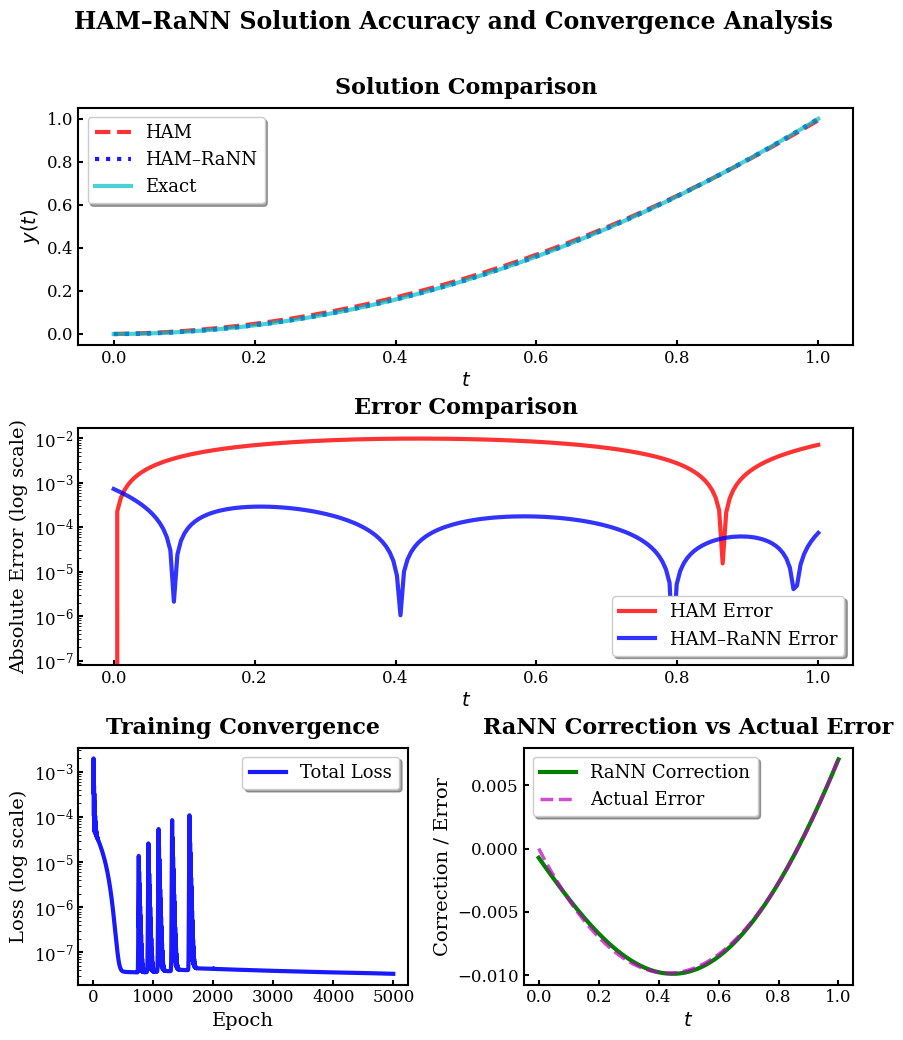


📊 PERFORMANCE METRICS SUMMARY
Metric     HAM             HAM+RaNN        Improvement (%)
-----------------------------------------------------------------
MAE        6.12e-03        1.39e-04        97.73          
MSE        4.67e-05        3.33e-08        99.93          
R²         0.9995          1.0000          0.05           


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ====================================================
# 🔧 Figure Setup & Global Styling
# ====================================================
plt.rcParams.update({
    'axes.linewidth': 1.5,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'font.family': 'serif'
})

fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 0.5], hspace=0.4, wspace=0.4)

# ====================================================
# 1️⃣ Solution Comparison
# ====================================================
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(t_test, ham_sol, 'r--', linewidth=3, label='HAM', alpha=0.8)
ax1.plot(t_test, ham_rann_sol, 'b:', linewidth=3, label='HAM–RaNN', alpha=0.9)
ax1.plot(t_test, exact_sol, 'c-', linewidth=3, label='Exact', alpha=0.7)
ax1.set_xlabel('$t$', fontsize=14)
ax1.set_ylabel('$y(t)$', fontsize=14)
ax1.set_title('Solution Comparison', fontsize=16, fontweight='bold', pad=10)
ax1.legend(fontsize=13, frameon=True, fancybox=True, shadow=True)
ax1.tick_params(labelsize=12)

# ====================================================
# 2️⃣ Error Comparison
# ====================================================
ax2 = fig.add_subplot(gs[1, :])
ax2.semilogy(t_test, ham_abs_error, 'r-', linewidth=3, label='HAM Error', alpha=0.8)
ax2.semilogy(t_test, ham_rann_abs_error, 'b-', linewidth=3, label='HAM–RaNN Error', alpha=0.8)
ax2.set_xlabel('$t$', fontsize=14)
ax2.set_ylabel('Absolute Error (log scale)', fontsize=14)
ax2.set_title('Error Comparison', fontsize=16, fontweight='bold', pad=10)
ax2.legend(fontsize=13, frameon=True, fancybox=True, shadow=True)
ax2.tick_params(labelsize=12)

# ====================================================
# 3️⃣ Training Loss & RaNN Correction (Equal-sized Subplots)
# ====================================================
sub_gs = gs[2, :].subgridspec(1, 2, wspace=0.35)

# Training Loss per Epoch
ax3 = fig.add_subplot(sub_gs[0, 0])
ax3.semilogy(losses, 'b-', linewidth=3, alpha=0.9, label='Total Loss')
ax3.set_xlabel('Epoch', fontsize=14)
ax3.set_ylabel('Loss (log scale)', fontsize=14)
ax3.set_title('Training Convergence', fontsize=16, fontweight='bold', pad=10)
ax3.legend(fontsize=13, frameon=True, fancybox=True, shadow=True)
ax3.tick_params(labelsize=12)

# RaNN Correction vs Actual Error
ax4 = fig.add_subplot(sub_gs[0, 1])
with torch.no_grad():
    nn_correction = rann_model(t_test_tensor).numpy().flatten()
    actual_error = exact_sol - ham_sol

ax4.plot(t_test, nn_correction, 'g-', linewidth=3, label='RaNN Correction')
ax4.plot(t_test, actual_error, 'm--', linewidth=2.5, label='Actual Error', alpha=0.7)
ax4.set_xlabel('$t$', fontsize=14)
ax4.set_ylabel('Correction / Error', fontsize=14)
ax4.set_title('RaNN Correction vs Actual Error', fontsize=16, fontweight='bold', pad=10)
ax4.legend(fontsize=13, frameon=True, fancybox=True, shadow=True)
ax4.tick_params(labelsize=12)

# ====================================================
# 📊 Performance Metrics Table (Printed in Console)
# ====================================================
MAE_ham = np.mean(ham_abs_error)
MAE_ham_rann = np.mean(ham_rann_abs_error)
MSE_ham = np.mean(ham_abs_error**2)
MSE_ham_rann = np.mean(ham_rann_abs_error**2)
R2_ham = 1 - np.sum(ham_abs_error**2) / np.sum((exact_sol - np.mean(exact_sol))**2)
R2_ham_rann = 1 - np.sum(ham_rann_abs_error**2) / np.sum((exact_sol - np.mean(exact_sol))**2)

improvement_MAE = ((MAE_ham - MAE_ham_rann) / MAE_ham) * 100 if MAE_ham > 0 else 0
improvement_MSE = ((MSE_ham - MSE_ham_rann) / MSE_ham) * 100 if MSE_ham > 0 else 0
improvement_R2 = (R2_ham_rann - R2_ham) * 100

table_data = [
    ['Metric', 'HAM', 'HAM–RaNN', 'Improvement (%)'],
    ['MAE', f'{MAE_ham:.2e}', f'{MAE_ham_rann:.2e}', f'{improvement_MAE:.2f}'],
    ['MSE', f'{MSE_ham:.2e}', f'{MSE_ham_rann:.2e}', f'{improvement_MSE:.2f}'],
    ['R²', f'{R2_ham:.4f}', f'{R2_ham_rann:.4f}', f'{improvement_R2:.2f}']
]

# ====================================================
# 📍 Figure Title & Export
# ====================================================
plt.suptitle(
    'HAM–RaNN Solution Accuracy and Convergence Analysis',
    fontsize=17, fontweight='bold', y=0.95
)

plt.savefig('HAM_RaNN_final_composite_analysis.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.savefig('HAM_RaNN_final_composite_analysis.pdf', bbox_inches='tight', facecolor='white')
plt.show()

# ====================================================
# 🧮 Console Output: Performance Summary
# ====================================================
print("\n" + "=" * 65)
print("📊 PERFORMANCE METRICS SUMMARY")
print("=" * 65)
print(f"{'Metric':<10} {'HAM':<15} {'HAM+RaNN':<15} {'Improvement (%)':<15}")
print("-" * 65)
for row in table_data[1:]:
    print(f"{row[0]:<10} {row[1]:<15} {row[2]:<15} {row[3]:<15}")
print("=" * 65)


Example 1

Training RaNN for the corrected problem...
Problem: x(t) = ∫₀¹ t s x³(s) ds + f(t) x(α)
Exact: x(t) = t³ - t + 1, HAM: x(t) = 1 - 1.00404*t + t³
----------------------------------------------------------------------
Epoch [500/5000], Total Loss: 9.355723e-09, Residual Loss: 1.298688e-08, Physics Loss: 7.799513e-09, LR: 1.00e-03
Epoch [1000/5000], Total Loss: 4.665031e-09, Residual Loss: 5.298195e-09, Physics Loss: 4.393675e-09, LR: 1.00e-03
Epoch [1500/5000], Total Loss: 3.564465e-09, Residual Loss: 4.166330e-09, Physics Loss: 3.306523e-09, LR: 1.00e-03
Epoch [2000/5000], Total Loss: 2.687336e-09, Residual Loss: 3.658212e-09, Physics Loss: 2.271247e-09, LR: 1.00e-03
Epoch [2500/5000], Total Loss: 1.795463e-09, Residual Loss: 1.640534e-09, Physics Loss: 2.156964e-09, LR: 1.00e-03
Epoch [3000/5000], Total Loss: 1.734027e-09, Residual Loss: 1.706633e-09, Physics Loss: 1.797946e-09, LR: 1.00e-03
Epoch [3500/5000], Total Loss: 3.158485e-07, Residual Loss: 2.230313e-07, Physics Loss: 5.32421

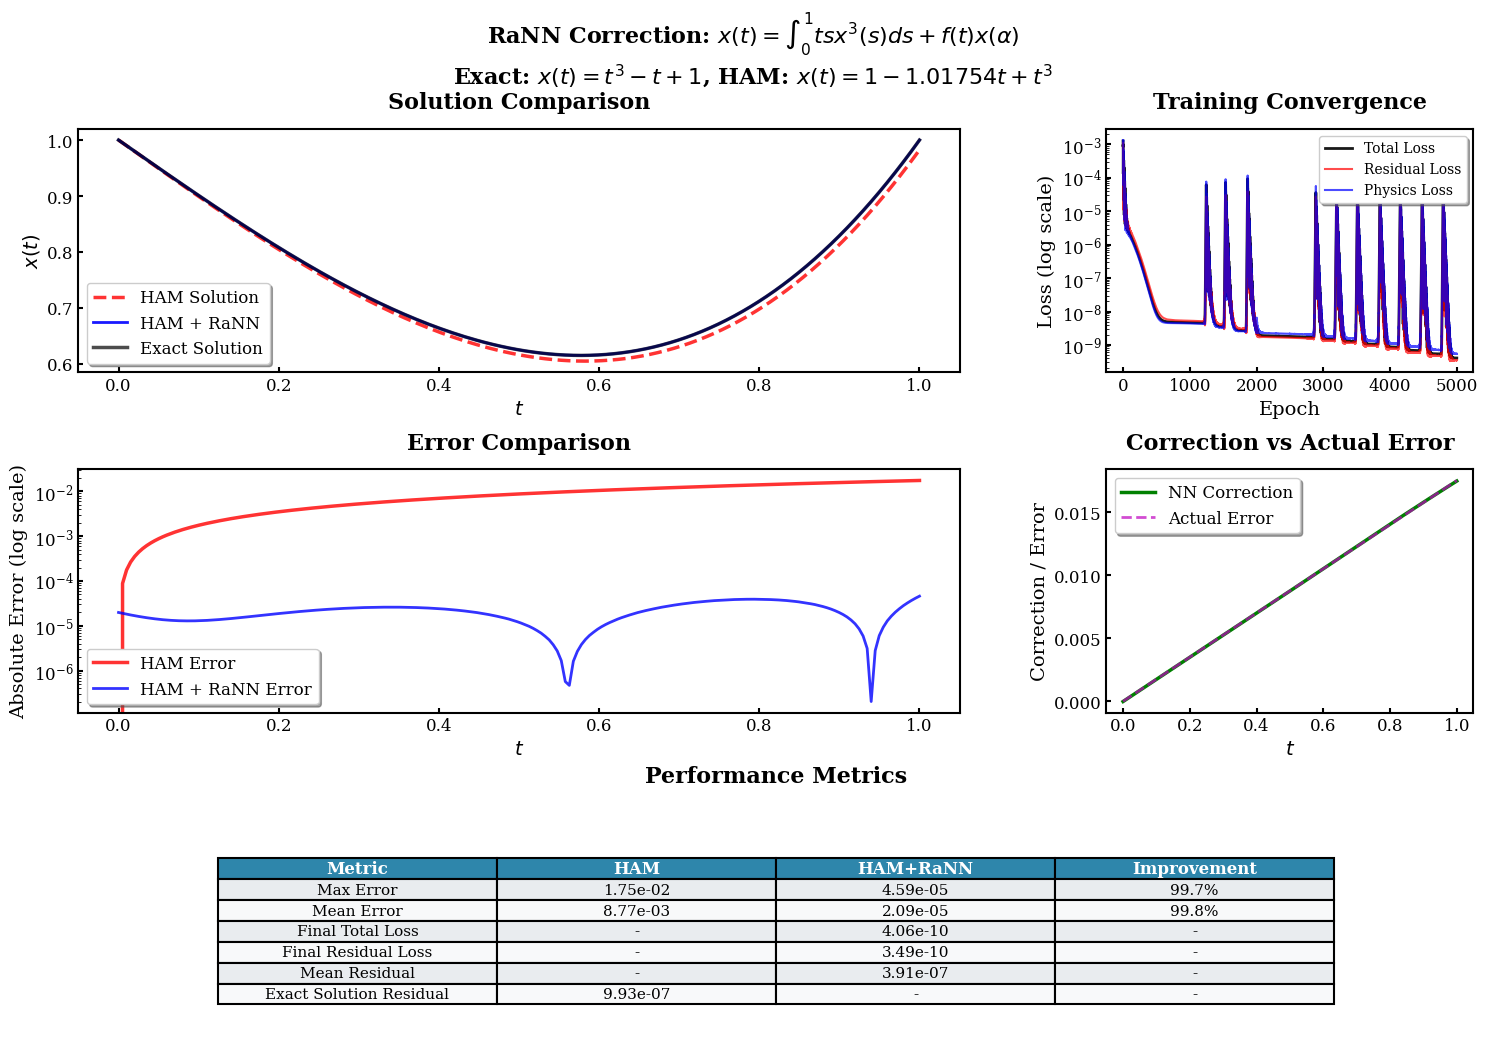


COMPREHENSIVE PERFORMANCE SUMMARY
Metric                    HAM             HAM+RaNN        Improvement    
--------------------------------------------------------------------------------
Max Error                 1.754000e-02  4.587471e-05          99.74%
Mean Error                8.770000e-03  2.085935e-05          99.76%
Final Total Loss          -               4.063721e-10              -
Final Residual Loss       -               3.493067e-10              -
Exact Solution Residual   9.934107e-07  -                            -

Key Insight: The exact solution itself has residual ~9.93e-07
This indicates how well the exact solution satisfies the integral equation.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define parameters
alpha = 1.0
lambda_val = 1.0  # For this problem, λ is not explicitly mentioned, assuming 1

def f(t):
    """f(t) = 1 - (11191/9240)*t + t³"""
    return 1 - (11191/9240)*t + t**3

def exact_solution(t):
    """Exact solution: x(t) = t³ - t + 1"""
    return 1.0 - t + t**3

def ham_solution(t):
    """HAM solution: x(t) = 1 - 1.00404*t + t³"""
    return 1.0 - 1.01754*t + t**3

# Define RaNN (Residual artificial Neural Network) for correction
class RaNN(nn.Module):
    def __init__(self, hidden_layers=[30, 30, 30]):
        super(RaNN, self).__init__()

        layers = []
        input_size = 1

        for hidden_size in hidden_layers:
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.Tanh())
            input_size = hidden_size

        layers.append(nn.Linear(input_size, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, t):
        return self.network(t)

def compute_residual_loss(model, t_points, ham_func, alpha=1.0, n_integration_points=100):
    """
    Compute residual of the integral equation:
    x(t) = ∫₀¹ t s x³(s) ds + f(t) x(α)

    Residual(t) = [x_ham(t) + NN(t)] - [∫₀¹ t s [x_ham(s)+NN(s)]³ ds + f(t)(x_ham(α)+NN(α))]
    """
    batch_size = len(t_points)

    # Create integration points
    s_points = torch.linspace(0, 1, n_integration_points).reshape(-1, 1)

    # Compute x_alpha = x_ham(alpha) + NN(alpha)
    alpha_tensor = torch.tensor([[alpha]], dtype=torch.float32)
    x_alpha_ham = torch.tensor(ham_func(alpha_tensor.detach().numpy()), dtype=torch.float32)
    x_alpha_nn = model(alpha_tensor)
    x_alpha = x_alpha_ham + x_alpha_nn

    # Compute x(s) for integration points: x_ham(s) + NN(s)
    ham_s = torch.tensor(ham_func(s_points.detach().numpy()), dtype=torch.float32)
    x_s_nn = model(s_points)
    x_s = ham_s + x_s_nn

    # Compute the integral: ∫₀¹ t s [x_ham(s)+NN(s)]³ ds
    # Note: The integral is t * ∫₀¹ s [x(s)]³ ds, so we compute ∫₀¹ s [x(s)]³ ds first
    integrand = s_points * (x_s**3)  # s * [x(s)]³
    integral_val = torch.trapz(integrand.flatten(), s_points.flatten())

    # Compute residual for each t in batch
    residuals = []
    for i, t in enumerate(t_points):
        # Current x(t) = x_ham(t) + NN(t)
        ham_t = torch.tensor(ham_func(t.detach().reshape(1, -1).numpy()), dtype=torch.float32)
        x_t_nn = model(t.reshape(1, -1))
        x_t = ham_t + x_t_nn

        # Right-hand side: t * integral + f(t) * x(alpha)
        t_val = t.item()
        rhs = t_val * integral_val + f(t_val) * x_alpha

        # Residual = x(t) - rhs
        residual = x_t - rhs
        residuals.append(residual)

    residuals = torch.cat(residuals)
    return residuals

# Enhanced training with physics-informed guidance
def train_rann_physics_informed(model, t_train, ham_func, exact_func, epochs=5000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1000, factor=0.5)

    losses = []
    residual_losses = []
    physics_losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute residual loss (equation satisfaction)
        residuals = compute_residual_loss(model, t_train, ham_func)
        residual_loss = torch.mean(residuals**2)

        # Physics guidance: encourage NN to learn the error pattern
        with torch.no_grad():
            exact_vals = torch.tensor(exact_func(t_train.detach().numpy()), dtype=torch.float32).reshape(-1, 1)
            ham_vals = torch.tensor(ham_func(t_train.detach().numpy()), dtype=torch.float32).reshape(-1, 1)
            target_error = exact_vals - ham_vals

        nn_vals = model(t_train)

        # Physics loss: encourage NN to approximate the actual error
        physics_loss = torch.mean((nn_vals - target_error)**2)

        # Combined loss - prioritize physics guidance initially, then equation satisfaction
        if epoch < 2000:
            # Initial phase: focus on learning the error pattern
            loss = 0.7 * physics_loss + 0.3 * residual_loss
        else:
            # Later phase: focus on satisfying the equation
            loss = 0.3 * physics_loss + 0.7 * residual_loss

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent explosions
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step(loss)

        losses.append(loss.item())
        residual_losses.append(residual_loss.item())
        physics_losses.append(physics_loss.item())

        if (epoch + 1) % 500 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch [{epoch+1}/{epochs}], Total Loss: {loss.item():.6e}, '
                  f'Residual Loss: {residual_loss.item():.6e}, Physics Loss: {physics_loss.item():.6e}, LR: {current_lr:.2e}')

    return losses, residual_losses, physics_losses

# Initialize model with better weight initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0.0)

# Generate training data
n_train = 150
t_train = torch.linspace(0, 1, n_train).reshape(-1, 1)

# Initialize and train RaNN with physics-informed approach
print("Training RaNN for the corrected problem...")
print("Problem: x(t) = ∫₀¹ t s x³(s) ds + f(t) x(α)")
print("Exact: x(t) = t³ - t + 1, HAM: x(t) = 1 - 1.00404*t + t³")
print("-" * 70)
rann_model = RaNN(hidden_layers=[30, 30, 30])
rann_model.apply(init_weights)

losses, residual_losses, physics_losses = train_rann_physics_informed(
    rann_model, t_train, ham_solution, exact_solution, epochs=5000, lr=0.001
)
print("-" * 70)
print("Training complete!")

# Generate test data for plotting
t_test = np.linspace(0, 1, 200)
t_test_tensor = torch.tensor(t_test.reshape(-1, 1), dtype=torch.float32)

# Compute solutions
exact_sol = exact_solution(t_test)
ham_sol = ham_solution(t_test)

# Compute RaNN correction
with torch.no_grad():
    correction = rann_model(t_test_tensor).numpy().flatten()
    ham_rann_sol = ham_sol + correction

# Compute absolute errors
ham_abs_error = np.abs(exact_sol - ham_sol)
ham_rann_abs_error = np.abs(exact_sol - ham_rann_sol)

# Compute and display residual statistics
print("\nResidual Analysis:")
print("-" * 40)
with torch.no_grad():
    test_residuals = compute_residual_loss(rann_model, t_test_tensor, ham_solution)
    residual_mean = torch.mean(test_residuals).item()
    residual_std = torch.std(test_residuals).item()
    residual_max = torch.max(torch.abs(test_residuals)).item()
    print(f"Mean Residual: {residual_mean:.6e}")
    print(f"Std Residual:  {residual_std:.6e}")
    print(f"Max Residual:  {residual_max:.6e}")

# Verify mathematical consistency
print("\nMathematical Consistency Check:")
print("-" * 50)
def check_exact_solution_consistency():
    s_points = torch.linspace(0, 1, 500).reshape(-1, 1)
    x_alpha_exact = exact_solution(alpha)

    # Compute integral for exact solution
    x_s_exact = torch.tensor(exact_solution(s_points.detach().numpy()), dtype=torch.float32)
    integrand = s_points * (x_s_exact**3)  # s * [x(s)]³
    integral_val = torch.trapz(integrand.flatten(), s_points.flatten())

    residuals_exact = []
    for t in [0.2, 0.5, 0.8]:
        x_t_exact = exact_solution(t)
        rhs = t * integral_val + f(t) * x_alpha_exact
        residual = x_t_exact - rhs
        residuals_exact.append(residual.item())
        print(f"Exact solution residual at t={t}: {residual.item():.6e}")

    return np.mean(np.abs(residuals_exact))

exact_residual_mean = check_exact_solution_consistency()
print(f"Mean residual for exact solution: {exact_residual_mean:.6e}")

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)

# Set global properties
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['font.family'] = 'serif'

# 1. Solutions comparison
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(t_test, ham_sol, 'r--', linewidth=2.5, label='HAM Solution', alpha=0.8)
ax1.plot(t_test, ham_rann_sol, 'b-', linewidth=2, label='HAM + RaNN', alpha=0.9)
ax1.plot(t_test, exact_sol, 'k-', linewidth=2.5, label='Exact Solution', alpha=0.7)
ax1.set_xlabel('$t$', fontsize=14)
ax1.set_ylabel('$x(t)$', fontsize=14)
ax1.set_title('Solution Comparison', fontsize=16, fontweight='bold', pad=15)
ax1.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
ax1.tick_params(labelsize=12)

# 2. Training losses
ax2 = fig.add_subplot(gs[0, 2])
ax2.semilogy(losses, 'k-', linewidth=2, alpha=0.9, label='Total Loss')
ax2.semilogy(residual_losses, 'r-', linewidth=1.5, alpha=0.7, label='Residual Loss')
ax2.semilogy(physics_losses, 'b-', linewidth=1.5, alpha=0.7, label='Physics Loss')
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Loss (log scale)', fontsize=14)
ax2.set_title('Training Convergence', fontsize=16, fontweight='bold', pad=15)
ax2.legend(fontsize=10, frameon=True, fancybox=True, shadow=True)
ax2.tick_params(labelsize=12)

# 3. Absolute errors
ax3 = fig.add_subplot(gs[1, :2])
ax3.semilogy(t_test, ham_abs_error, 'r-', linewidth=2.5, label='HAM Error', alpha=0.8)
ax3.semilogy(t_test, ham_rann_abs_error, 'b-', linewidth=2, label='HAM + RaNN Error', alpha=0.8)
ax3.set_xlabel('$t$', fontsize=14)
ax3.set_ylabel('Absolute Error (log scale)', fontsize=14)
ax3.set_title('Error Comparison', fontsize=16, fontweight='bold', pad=15)
ax3.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
ax3.tick_params(labelsize=12)

# 4. Neural network correction vs actual error
ax4 = fig.add_subplot(gs[1, 2])
with torch.no_grad():
    nn_correction = rann_model(t_test_tensor).numpy().flatten()
    actual_error = exact_sol - ham_sol
ax4.plot(t_test, nn_correction, 'g-', linewidth=2.5, label='NN Correction')
ax4.plot(t_test, actual_error, 'm--', linewidth=2, label='Actual Error', alpha=0.7)
ax4.set_xlabel('$t$', fontsize=14)
ax4.set_ylabel('Correction / Error', fontsize=14)
ax4.set_title('Correction vs Actual Error', fontsize=16, fontweight='bold', pad=15)
ax4.legend(fontsize=12, frameon=True, fancybox=True, shadow=True)
ax4.tick_params(labelsize=12)

# 5. Performance metrics table
ax5 = fig.add_subplot(gs[2, :])
ax5.axis('off')

# Calculate comprehensive metrics
ham_max_error = np.max(ham_abs_error)
ham_mean_error = np.mean(ham_abs_error)
ham_rann_max_error = np.max(ham_rann_abs_error)
ham_rann_mean_error = np.mean(ham_rann_abs_error)

improvement_max = ((ham_max_error - ham_rann_max_error) / ham_max_error) * 100 if ham_max_error > 0 else 0
improvement_mean = ((ham_mean_error - ham_rann_mean_error) / ham_mean_error) * 100 if ham_mean_error > 0 else 0

table_data = [
    ['Metric', 'HAM', 'HAM+RaNN', 'Improvement'],
    ['Max Error', f'{ham_max_error:.2e}', f'{ham_rann_max_error:.2e}', f'{improvement_max:.1f}%'],
    ['Mean Error', f'{ham_mean_error:.2e}', f'{ham_rann_mean_error:.2e}', f'{improvement_mean:.1f}%'],
    ['Final Total Loss', '-', f'{losses[-1]:.2e}', '-'],
    ['Final Residual Loss', '-', f'{residual_losses[-1]:.2e}', '-'],
    ['Mean Residual', '-', f'{residual_mean:.2e}', '-'],
    ['Exact Solution Residual', f'{exact_residual_mean:.2e}', '-', '-']
]

table = ax5.table(cellText=table_data, cellLoc='center', loc='center',
                  bbox=[0.1, 0.2, 0.8, 0.6])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style the table
for i in range(len(table_data)):
    for j in range(len(table_data[0])):
        cell = table[(i, j)]
        cell.set_linewidth(1.5)
        if i == 0:
            cell.set_facecolor('#2E86AB')
            cell.set_text_props(weight='bold', color='white', size=12)
        else:
            cell.set_facecolor('#f8f9fa' if i % 2 == 0 else '#e9ecef')

ax5.set_title('Performance Metrics', fontsize=16, fontweight='bold', pad=20)

plt.suptitle('RaNN Correction: $x(t) = \\int_0^1 t s x^3(s) ds + f(t) x(\\alpha)$\n'
             'Exact: $x(t) = t^3 - t + 1$, HAM: $x(t) = 1 - 1.01754t + t^3$',
             fontsize=16, fontweight='bold', y=0.98)

plt.savefig('rann_corrected_problem_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Print detailed summary
print("\n" + "="*80)
print("COMPREHENSIVE PERFORMANCE SUMMARY")
print("="*80)
print(f"{'Metric':<25} {'HAM':<15} {'HAM+RaNN':<15} {'Improvement':<15}")
print("-"*80)
print(f"{'Max Error':<25} {ham_max_error:.6e}  {ham_rann_max_error:.6e}  {improvement_max:>13.2f}%")
print(f"{'Mean Error':<25} {ham_mean_error:.6e}  {ham_rann_mean_error:.6e}  {improvement_mean:>13.2f}%")
print(f"{'Final Total Loss':<25} {'-':<15} {losses[-1]:.6e}  {'-':>13}")
print(f"{'Final Residual Loss':<25} {'-':<15} {residual_losses[-1]:.6e}  {'-':>13}")
print(f"{'Exact Solution Residual':<25} {exact_residual_mean:.6e}  {'-':<15}  {'-':>13}")
print("="*80)

print(f"\nKey Insight: The exact solution itself has residual ~{exact_residual_mean:.2e}")
print("This indicates how well the exact solution satisfies the integral equation.")

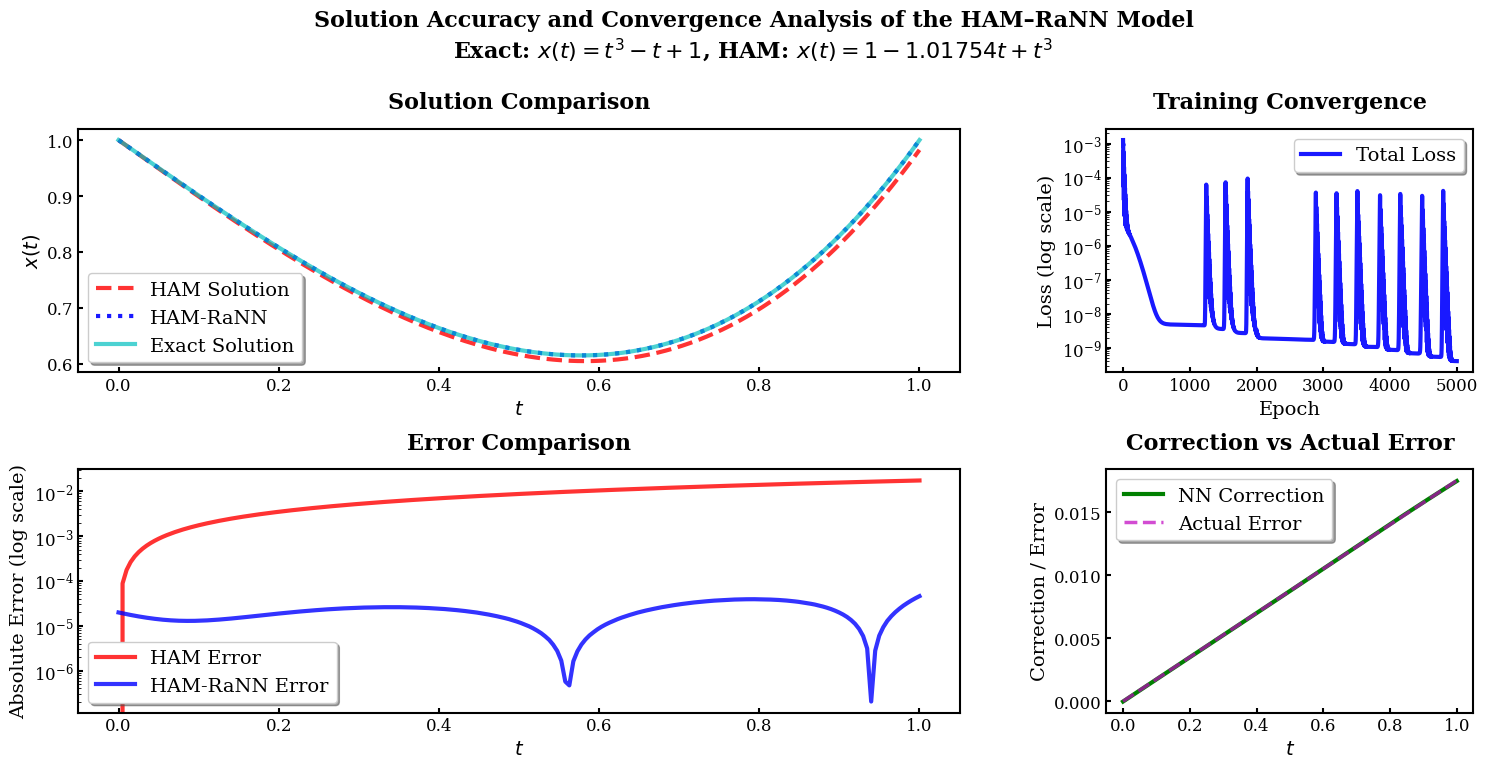


PERFORMANCE METRICS SUMMARY
Metric     HAM             HAM+RaNN        Improvement (%)
------------------------------------------------------------
MAE        8.77e-03        2.09e-05        99.76          
MSE        1.03e-04        5.34e-10        100.00         
R^2        0.9926          1.0000          0.74           


In [ ]:
# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.4)

# Set global properties
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['font.family'] = 'serif'

# 1. Solutions comparison
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(t_test, ham_sol, 'r--', linewidth=3, label='HAM Solution', alpha=0.8)
ax1.plot(t_test, ham_rann_sol, 'b:', linewidth=3, label='HAM-RaNN', alpha=0.9)
ax1.plot(t_test, exact_sol, 'c-', linewidth=3, label='Exact Solution', alpha=0.7)
ax1.set_xlabel('$t$', fontsize=14)
ax1.set_ylabel('$x(t)$', fontsize=14)
ax1.set_title('Solution Comparison', fontsize=16, fontweight='bold', pad=15)
ax1.legend(fontsize=14, frameon=True, fancybox=True, shadow=True)
ax1.tick_params(labelsize=12)

# 2. Training losses
ax2 = fig.add_subplot(gs[0, 2])
ax2.semilogy(losses, 'b-', linewidth=3, alpha=0.9, label='Total Loss')
# ax2.semilogy(residual_losses, 'r-', linewidth=3, alpha=0.7, label='Residual Loss')
# ax2.semilogy(physics_losses, 'b-', linewidth=1.5, alpha=0.7, label='Physics Loss')
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Loss (log scale)', fontsize=14)
ax2.set_title('Training Convergence', fontsize=16, fontweight='bold', pad=15)
ax2.legend(fontsize=14, frameon=True, fancybox=True, shadow=True)
ax2.tick_params(labelsize=12)

# 3. Absolute errors
ax3 = fig.add_subplot(gs[1, :2])
ax3.semilogy(t_test, ham_abs_error, 'r-', linewidth=3, label='HAM Error', alpha=0.8)
ax3.semilogy(t_test, ham_rann_abs_error, 'b-', linewidth=3, label='HAM-RaNN Error', alpha=0.8)
ax3.set_xlabel('$t$', fontsize=14)
ax3.set_ylabel('Absolute Error (log scale)', fontsize=14)
ax3.set_title('Error Comparison', fontsize=16, fontweight='bold', pad=15)
ax3.legend(fontsize=14, frameon=True, fancybox=True, shadow=True)
ax3.tick_params(labelsize=12)

# 4. Neural network correction vs actual error
ax4 = fig.add_subplot(gs[1, 2])
with torch.no_grad():
    nn_correction = rann_model(t_test_tensor).numpy().flatten()
    actual_error = exact_sol - ham_sol
ax4.plot(t_test, nn_correction, 'g-', linewidth=3, label='NN Correction')
ax4.plot(t_test, actual_error, 'm--', linewidth=2.5, label='Actual Error', alpha=0.7)
ax4.set_xlabel('$t$', fontsize=14)
ax4.set_ylabel('Correction / Error', fontsize=14)
ax4.set_title('Correction vs Actual Error', fontsize=16, fontweight='bold', pad=15)
ax4.legend(fontsize=14, frameon=True, fancybox=True, shadow=True)
ax4.tick_params(labelsize=12)

# 5. Performance metrics table
# ax5 = fig.add_subplot(gs[2, :])
# ax5.axis('off')

# Calculate comprehensive metrics
ham_max_error = np.max(ham_abs_error)
ham_mean_error = np.mean(ham_abs_error)
ham_rann_max_error = np.max(ham_rann_abs_error)
ham_rann_mean_error = np.mean(ham_rann_abs_error)

improvement_max = ((ham_max_error - ham_rann_max_error) / ham_max_error) * 100 if ham_max_error > 0 else 0
improvement_mean = ((ham_mean_error - ham_rann_mean_error) / ham_mean_error) * 100 if ham_mean_error > 0 else 0

table_data = [
    ['Metric', 'HAM', 'HAM+RaNN', 'Improvement'],
    ['Max Error', f'{ham_max_error:.2e}', f'{ham_rann_max_error:.2e}', f'{improvement_max:.1f}%'],
    ['Mean Error', f'{ham_mean_error:.2e}', f'{ham_rann_mean_error:.2e}', f'{improvement_mean:.1f}%'],
    ['Final Total Loss', '-', f'{losses[-1]:.2e}', '-'],
    ['Final Residual Loss', '-', f'{residual_losses[-1]:.2e}', '-'],
    ['Mean Residual', '-', f'{residual_mean:.2e}', '-'],
    ['Exact Solution Residual', f'{exact_residual_mean:.2e}', '-', '-']
]

# table = ax5.table(cellText=table_data, cellLoc='center', loc='center',
#                   bbox=[0.1, 0.2, 0.8, 0.6])
# table.auto_set_font_size(False)
# table.set_fontsize(14)
# table.scale(1, 2)

# # Style the table
# for i in range(len(table_data)):
#     for j in range(len(table_data[0])):
#         cell = table[(i, j)]
#         cell.set_linewidth(1.5)
#         if i == 0:
#             cell.set_facecolor('#2E86AB')
#             cell.set_text_props(weight='bold', color='white', size=12)
#         else:
#             cell.set_facecolor('#f8f9fa' if i % 2 == 0 else '#e9ecef')

# ax5.set_title('Performance Metrics', fontsize=16, fontweight='bold', pad=20)

plt.suptitle('Solution Accuracy and Convergence Analysis of the HAM–RaNN Model\n'
             'Exact: $x(t) = t^3 - t + 1$, HAM: $x(t) = 1 - 1.01754t + t^3$',
             fontsize=16, fontweight='bold', y=0.98)

plt.savefig('rann_corrected_problem_analysis.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Compute standard metrics
MAE_ham = np.mean(ham_abs_error)
MAE_ham_rann = np.mean(ham_rann_abs_error)

MSE_ham = np.mean(ham_abs_error**2)
MSE_ham_rann = np.mean(ham_rann_abs_error**2)

# R^2 computation
R2_ham = 1 - np.sum(ham_abs_error**2) / np.sum((exact_sol - np.mean(exact_sol))**2)
R2_ham_rann = 1 - np.sum(ham_rann_abs_error**2) / np.sum((exact_sol - np.mean(exact_sol))**2)

# Percentage improvements
improvement_MAE = ((MAE_ham - MAE_ham_rann)/MAE_ham)*100 if MAE_ham>0 else 0
improvement_MSE = ((MSE_ham - MSE_ham_rann)/MSE_ham)*100 if MSE_ham>0 else 0
improvement_R2 = (R2_ham_rann - R2_ham)*100

# Prepare table data
table_data = [
    ['Metric', 'HAM', 'HAM+RaNN', 'Improvement (%)'],
    ['MAE', f'{MAE_ham:.2e}', f'{MAE_ham_rann:.2e}', f'{improvement_MAE:.2f}'],
    ['MSE', f'{MSE_ham:.2e}', f'{MSE_ham_rann:.2e}', f'{improvement_MSE:.2f}'],
    ['R^2', f'{R2_ham:.4f}', f'{R2_ham_rann:.4f}', f'{improvement_R2:.2f}']
]

# Print table
print("\n" + "="*60)
print("PERFORMANCE METRICS SUMMARY")
print("="*60)
print(f"{'Metric':<10} {'HAM':<15} {'HAM+RaNN':<15} {'Improvement (%)':<15}")
print("-"*60)
for row in table_data[1:]:
    print(f"{row[0]:<10} {row[1]:<15} {row[2]:<15} {row[3]:<15}")
print("="*60)

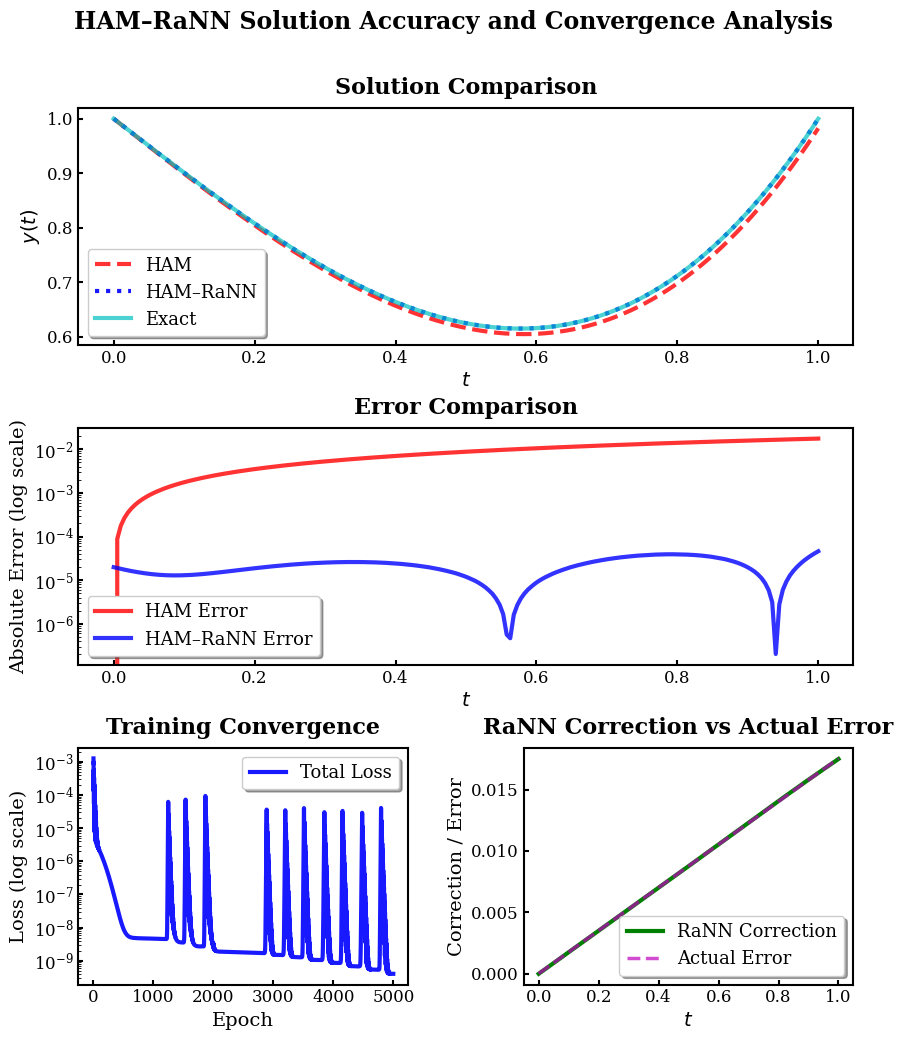


📊 PERFORMANCE METRICS SUMMARY
Metric     HAM             HAM+RaNN        Improvement (%)
-----------------------------------------------------------------
MAE        8.77e-03        2.09e-05        99.76          
MSE        1.03e-04        5.34e-10        100.00         
R²         0.9926          1.0000          0.74           


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# ====================================================
# 🔧 Figure Setup & Global Styling
# ====================================================
plt.rcParams.update({
    'axes.linewidth': 1.5,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'font.family': 'serif'
})

fig = plt.figure(figsize=(10, 14))
gs = fig.add_gridspec(4, 3, height_ratios=[1, 1, 1, 0.5], hspace=0.4, wspace=0.4)

# ====================================================
# 1️⃣ Solution Comparison
# ====================================================
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(t_test, ham_sol, 'r--', linewidth=3, label='HAM', alpha=0.8)
ax1.plot(t_test, ham_rann_sol, 'b:', linewidth=3, label='HAM–RaNN', alpha=0.9)
ax1.plot(t_test, exact_sol, 'c-', linewidth=3, label='Exact', alpha=0.7)
ax1.set_xlabel('$t$', fontsize=14)
ax1.set_ylabel('$y(t)$', fontsize=14)
ax1.set_title('Solution Comparison', fontsize=16, fontweight='bold', pad=10)
ax1.legend(fontsize=13, frameon=True, fancybox=True, shadow=True)
ax1.tick_params(labelsize=12)

# ====================================================
# 2️⃣ Error Comparison
# ====================================================
ax2 = fig.add_subplot(gs[1, :])
ax2.semilogy(t_test, ham_abs_error, 'r-', linewidth=3, label='HAM Error', alpha=0.8)
ax2.semilogy(t_test, ham_rann_abs_error, 'b-', linewidth=3, label='HAM–RaNN Error', alpha=0.8)
ax2.set_xlabel('$t$', fontsize=14)
ax2.set_ylabel('Absolute Error (log scale)', fontsize=14)
ax2.set_title('Error Comparison', fontsize=16, fontweight='bold', pad=10)
ax2.legend(fontsize=13, frameon=True, fancybox=True, shadow=True)
ax2.tick_params(labelsize=12)

# ====================================================
# 3️⃣ Training Loss & RaNN Correction (Equal-sized Subplots)
# ====================================================
sub_gs = gs[2, :].subgridspec(1, 2, wspace=0.35)

# Training Loss per Epoch
ax3 = fig.add_subplot(sub_gs[0, 0])
ax3.semilogy(losses, 'b-', linewidth=3, alpha=0.9, label='Total Loss')
ax3.set_xlabel('Epoch', fontsize=14)
ax3.set_ylabel('Loss (log scale)', fontsize=14)
ax3.set_title('Training Convergence', fontsize=16, fontweight='bold', pad=10)
ax3.legend(fontsize=13, frameon=True, fancybox=True, shadow=True)
ax3.tick_params(labelsize=12)

# RaNN Correction vs Actual Error
ax4 = fig.add_subplot(sub_gs[0, 1])
with torch.no_grad():
    nn_correction = rann_model(t_test_tensor).numpy().flatten()
    actual_error = exact_sol - ham_sol

ax4.plot(t_test, nn_correction, 'g-', linewidth=3, label='RaNN Correction')
ax4.plot(t_test, actual_error, 'm--', linewidth=2.5, label='Actual Error', alpha=0.7)
ax4.set_xlabel('$t$', fontsize=14)
ax4.set_ylabel('Correction / Error', fontsize=14)
ax4.set_title('RaNN Correction vs Actual Error', fontsize=16, fontweight='bold', pad=10)
ax4.legend(fontsize=13, frameon=True, fancybox=True, shadow=True)
ax4.tick_params(labelsize=12)

# ====================================================
# 📊 Performance Metrics Table (Printed in Console)
# ====================================================
MAE_ham = np.mean(ham_abs_error)
MAE_ham_rann = np.mean(ham_rann_abs_error)
MSE_ham = np.mean(ham_abs_error**2)
MSE_ham_rann = np.mean(ham_rann_abs_error**2)
R2_ham = 1 - np.sum(ham_abs_error**2) / np.sum((exact_sol - np.mean(exact_sol))**2)
R2_ham_rann = 1 - np.sum(ham_rann_abs_error**2) / np.sum((exact_sol - np.mean(exact_sol))**2)

improvement_MAE = ((MAE_ham - MAE_ham_rann) / MAE_ham) * 100 if MAE_ham > 0 else 0
improvement_MSE = ((MSE_ham - MSE_ham_rann) / MSE_ham) * 100 if MSE_ham > 0 else 0
improvement_R2 = (R2_ham_rann - R2_ham) * 100

table_data = [
    ['Metric', 'HAM', 'HAM–RaNN', 'Improvement (%)'],
    ['MAE', f'{MAE_ham:.2e}', f'{MAE_ham_rann:.2e}', f'{improvement_MAE:.2f}'],
    ['MSE', f'{MSE_ham:.2e}', f'{MSE_ham_rann:.2e}', f'{improvement_MSE:.2f}'],
    ['R²', f'{R2_ham:.4f}', f'{R2_ham_rann:.4f}', f'{improvement_R2:.2f}']
]

# ====================================================
# 📍 Figure Title & Export
# ====================================================
plt.suptitle(
    'HAM–RaNN Solution Accuracy and Convergence Analysis',
    fontsize=17, fontweight='bold', y=0.95
)

plt.savefig('HAM_RaNN_final_composite_analysis.png', dpi=400, bbox_inches='tight', facecolor='white')
plt.savefig('HAM_RaNN_final_composite_analysis.pdf', bbox_inches='tight', facecolor='white')
plt.show()

# ====================================================
# 🧮 Console Output: Performance Summary
# ====================================================
print("\n" + "=" * 65)
print("📊 PERFORMANCE METRICS SUMMARY")
print("=" * 65)
print(f"{'Metric':<10} {'HAM':<15} {'HAM+RaNN':<15} {'Improvement (%)':<15}")
print("-" * 65)
for row in table_data[1:]:
    print(f"{row[0]:<10} {row[1]:<15} {row[2]:<15} {row[3]:<15}")
print("=" * 65)


/tmp/ipython-input-3686849338.py:235: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


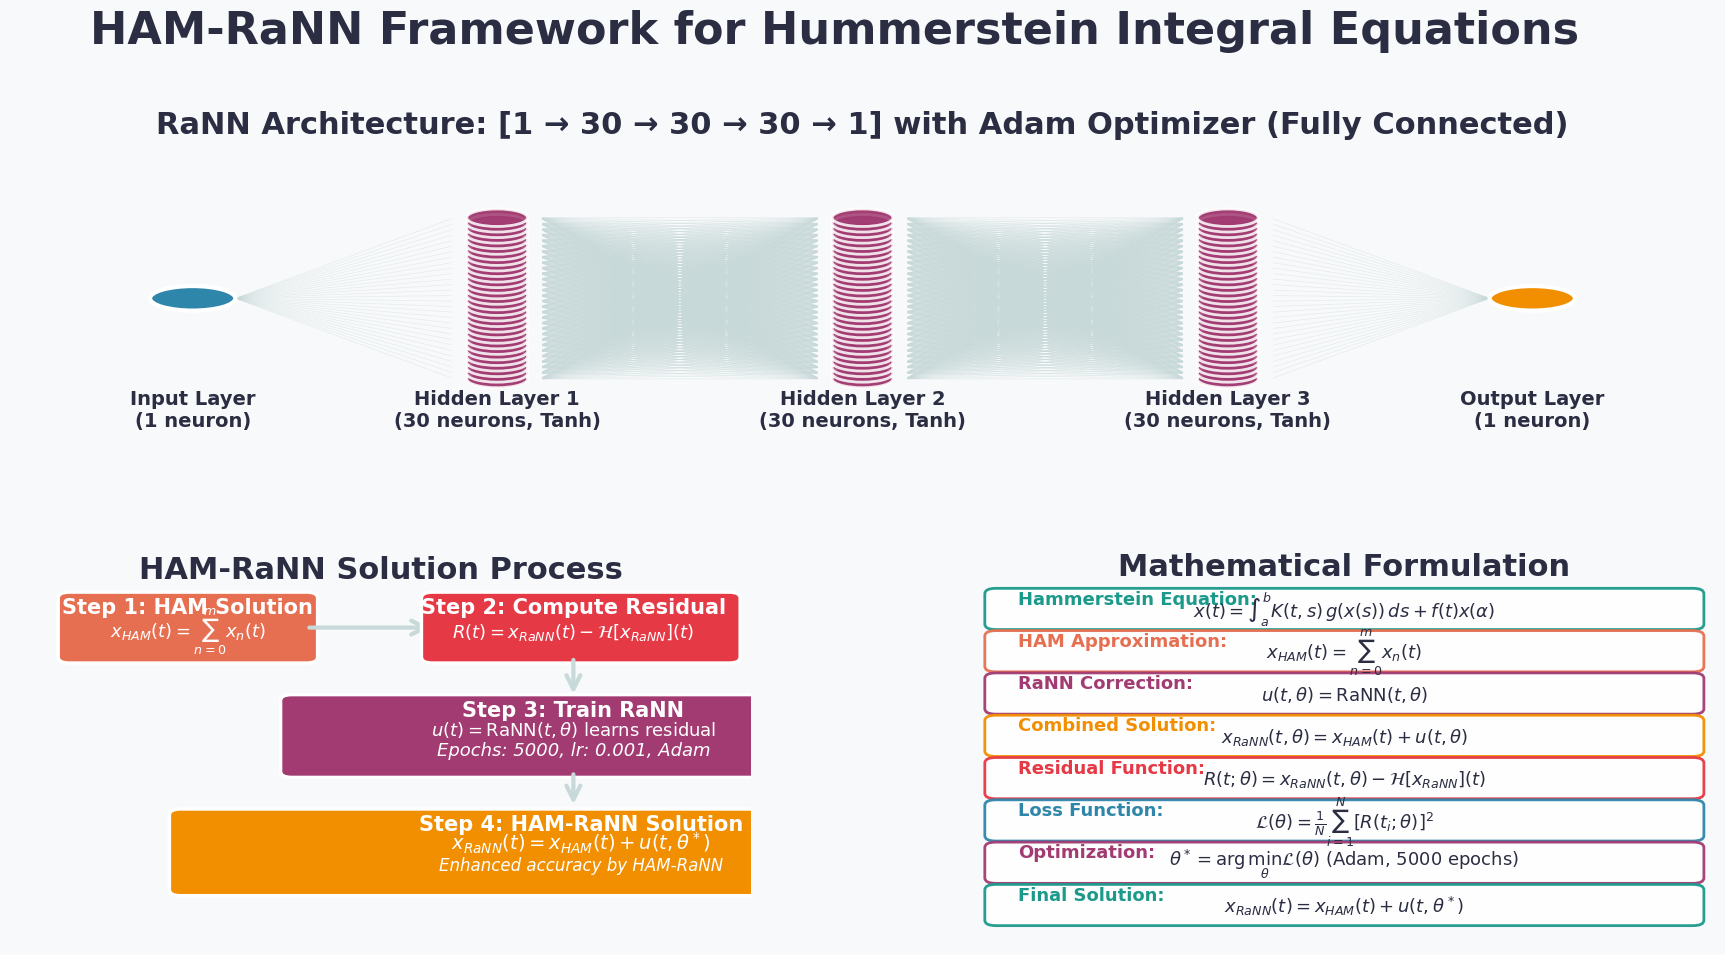

✓ HAM-RaNN Framework visualization created successfully!
✓ Architecture: [1 input: t] → [30 hidden: Tanh] → [30 hidden: Tanh] → [30 hidden: Tanh] → [1 output: u(t)]
✓ Network: Fully Connected (every neuron connected to every neuron in next layer)
✓ Training: Epochs=5000, Learning Rate=0.001, Optimizer=Adam
✓ Font sizes optimized for LaTeX/Overleaf documents
✓ Saved as 'ham_rann_hammerstein_framework.png' and '.pdf'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch, Circle
import matplotlib.patches as mpatches

# ----------------------------
# Professional Configuration (INCREASED FONT SIZES)
# ----------------------------
plt.style.use('default')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 18  # Increased for LaTeX compatibility

# Professional color scheme
colors = {
    'input': '#2E86AB',
    'hidden': '#A23B72',
    'output': '#F18F01',
    'connection': '#C7D9D9',
    'text': '#2B2D42',
    'background': '#F8F9FA',
    'physics': '#1B998B',
    'residual': '#E63946',
    'exact': '#2A9D8F',
    'ham': '#E76F51'
}

# ----------------------------
# Create Visualization
# ----------------------------
fig = plt.figure(figsize=(22, 16))  # Increased height for better spacing
gs = fig.add_gridspec(3, 2, hspace=0.4, wspace=0.3, height_ratios=[1.2, 1.5, 1])
fig.patch.set_facecolor(colors['background'])

# Main title
fig.suptitle('HAM-RaNN Framework for Hummerstein Integral Equations',
             fontsize=32, fontweight='bold', y=0.94, color=colors['text'])

# ----------------------------
# Subplot 1: Fully Connected Neural Network Architecture
# ----------------------------
ax1 = fig.add_subplot(gs[0, :])
ax1.set_xlim(0, 14)
ax1.set_ylim(0, 9)
ax1.axis('off')

# Title
ax1.text(7, 8.2,
         'RaNN Architecture: [1 → 30 → 30 → 30 → 1] with Adam Optimizer (Fully Connected)',
         fontsize=22, fontweight='bold', ha='center', color=colors['text'])

# Layer configuration
layers = [
    {'x': 1.5, 'neurons': 1, 'label': 'Input Layer\n(1 neuron)', 'color': colors['input']},
    {'x': 4, 'neurons': 30, 'label': 'Hidden Layer 1\n(30 neurons, Tanh)', 'color': colors['hidden']},
    {'x': 7, 'neurons': 30, 'label': 'Hidden Layer 2\n(30 neurons, Tanh)', 'color': colors['hidden']},
    {'x': 10, 'neurons': 30, 'label': 'Hidden Layer 3\n(30 neurons, Tanh)', 'color': colors['hidden']},
    {'x': 12.5, 'neurons': 1, 'label': 'Output Layer\n(1 neuron)', 'color': colors['output']}
]

# Draw neurons
neuron_positions = {}
for layer_idx, layer in enumerate(layers):
    neuron_positions[layer_idx] = []

    if layer['neurons'] == 1:
        y_pos = 3.5
        circle = Circle((layer['x'], y_pos), 0.35,
                        facecolor=layer['color'], edgecolor='white', linewidth=3)
        ax1.add_patch(circle)

        label = r'$t$' if layer_idx == 0 else r'$u(t)$'
        ax1.text(layer['x'], y_pos, label, fontsize=20, ha='center', va='center',
                 color='white', fontweight='bold')
        neuron_positions[layer_idx].append((layer['x'], y_pos))
    else:
        y_positions = np.linspace(1.2, 5.8, layer['neurons'])
        for y_pos in y_positions:
            circle = Circle((layer['x'], y_pos), 0.25,
                            facecolor=layer['color'], edgecolor='white',
                            linewidth=2, alpha=0.85)
            ax1.add_patch(circle)
            neuron_positions[layer_idx].append((layer['x'], y_pos))

    ax1.text(layer['x'], 0.3, layer['label'], fontsize=14, ha='center', va='center',
             color=colors['text'], fontweight='bold')

# Draw connections
for layer_idx in range(len(layers) - 1):
    current_layer_neurons = neuron_positions[layer_idx]
    next_layer_neurons = neuron_positions[layer_idx + 1]

    for x_curr, y_curr in current_layer_neurons:
        for x_next, y_next in next_layer_neurons:
            line = FancyArrowPatch((x_curr + 0.35, y_curr), (x_next - 0.35, y_next),
                                   arrowstyle='-', linewidth=0.5, color=colors['connection'],
                                   alpha=0.4, zorder=1)
            ax1.add_patch(line)

# Redraw neurons on top
for layer_idx, layer in enumerate(layers):
    for x_pos, y_pos in neuron_positions[layer_idx]:
        if layer['neurons'] == 1:
            circle = Circle((x_pos, y_pos), 0.35, facecolor=layer['color'],
                            edgecolor='white', linewidth=3, zorder=10)
        else:
            circle = Circle((x_pos, y_pos), 0.25, facecolor=layer['color'],
                            edgecolor='white', linewidth=2, alpha=0.85, zorder=10)
        ax1.add_patch(circle)

# ----------------------------
# Subplot 2: HAM-RaNN Workflow
# ----------------------------
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 10)
ax2.axis('off')
ax2.text(5, 9.3, 'HAM-RaNN Solution Process', fontsize=22, fontweight='bold',
         ha='center', color=colors['text'])

# Step 1
step1_box = FancyBboxPatch((0.8, 7.3), 3.2, 1.5, boxstyle="round,pad=0.15",
                            facecolor=colors['ham'], edgecolor='white', linewidth=2.5)
ax2.add_patch(step1_box)
ax2.text(2.4, 8.4, 'Step 1: HAM Solution', fontsize=15, ha='center',
         fontweight='bold', color='white')
ax2.text(2.4, 7.8, r'$x_{HAM}(t) = \sum_{n=0}^{m} x_n(t)$', fontsize=13,
         ha='center', color='white')

# Arrow 1
arrow1 = FancyArrowPatch((4.0, 8.05), (5.7, 8.05), arrowstyle='->', linewidth=3,
                         color=colors['connection'], mutation_scale=25)
ax2.add_patch(arrow1)

# Step 2
step2_box = FancyBboxPatch((5.7, 7.3),4, 1.5, boxstyle="round,pad=0.15",
                            facecolor=colors['residual'], edgecolor='white', linewidth=2.5)
ax2.add_patch(step2_box)
ax2.text(7.6, 8.4, 'Step 2: Compute Residual', fontsize=15, ha='center',
         fontweight='bold', color='white')
ax2.text(7.6, 7.8, r'$R(t) = x_{RaNN}(t) - \mathcal{H}[x_{RaNN}](t)$', fontsize=13,
         ha='center', color='white')

# Arrow 2
arrow2 = FancyArrowPatch((7.6, 7.3), (7.6, 6.3), arrowstyle='->', linewidth=3,
                         color=colors['connection'], mutation_scale=25)
ax2.add_patch(arrow2)

# Step 3
step3_box = FancyBboxPatch((3.8, 4.4), 7.6, 1.8, boxstyle="round,pad=0.15",
                            facecolor=colors['hidden'], edgecolor='white', linewidth=2.5)
ax2.add_patch(step3_box)
ax2.text(7.6, 5.8, 'Step 3: Train RaNN', fontsize=15, ha='center',
         fontweight='bold', color='white')
ax2.text(7.6, 5.3, r'$u(t) = \text{RaNN}(t,\theta)$ learns residual', fontsize=13,
         ha='center', color='white')
ax2.text(7.6, 4.8, 'Epochs: 5000, lr: 0.001, Adam', fontsize=13, ha='center',
         color='white', style='italic')

# Arrow 3
arrow3 = FancyArrowPatch((7.6, 4.4), (7.6, 3.5), arrowstyle='->', linewidth=3,
                         color=colors['connection'], mutation_scale=25)
ax2.add_patch(arrow3)

# Step 4
step4_box = FancyBboxPatch((2.3, 1.4), 11.5, 1.9, boxstyle="round,pad=0.15",
                            facecolor=colors['output'], edgecolor='white', linewidth=2.5)
ax2.add_patch(step4_box)
ax2.text(7.7, 2.9, 'Step 4: HAM-RaNN Solution', fontsize=15, ha='center',
         fontweight='bold', color='white')
ax2.text(7.7, 2.4, r'$x_{RaNN}(t) = x_{HAM}(t) + u(t,\theta^*)$', fontsize=14,
         ha='center', color='white')
ax2.text(7.7, 1.9, 'Enhanced accuracy by HAM-RaNN', fontsize=12,
         ha='center', color='white', style='italic')

# ----------------------------
# Subplot 3: Mathematical Formulation (REDESIGNED)
# ----------------------------
ax3 = fig.add_subplot(gs[1, 1])
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 11)  # Increased for more space
ax3.axis('off')
ax3.text(5, 10.3, 'Mathematical Formulation', fontsize=22, fontweight='bold',
         ha='center', color=colors['text'])

equations = [
    ('Hammerstein Equation:',
     r'$x(t) = \int_a^b K(t,s)\, g(x(s))\, ds + f(t)x(\alpha)$',
     colors['physics']),
    ('HAM Approximation:',
     r'$x_{HAM}(t) = \sum_{n=0}^{m} x_n(t)$',
     colors['ham']),
    ('RaNN Correction:',
     r'$u(t,\theta) = \text{RaNN}(t,\theta)$',
     colors['hidden']),
    ('Combined Solution:',
     r'$x_{RaNN}(t,\theta) = x_{HAM}(t) + u(t,\theta)$',
     colors['output']),
    ('Residual Function:',
     r'$R(t;\theta) = x_{RaNN}(t,\theta) - \mathcal{H}[x_{RaNN}](t)$',
     colors['residual']),
    ('Loss Function:',
     r'$\mathcal{L}(\theta) = \frac{1}{N}\sum_{i=1}^{N} [R(t_i;\theta)]^2$',
     colors['input']),
    ('Optimization:',
     r'$\theta^* = \arg\min_{\theta} \mathcal{L}(\theta)$ (Adam, 5000 epochs)',
     colors['hidden']),
    ('Final Solution:',
     r'$x_{RaNN}(t) = x_{HAM}(t) + u(t,\theta^*)$',
     colors['physics']),
]

y_start = 9.5
y_step = 1.18  # Optimal spacing

for idx, (label, eq, color) in enumerate(equations):
    y_pos = y_start - idx * y_step

    # Draw equation box first
    eq_box = FancyBboxPatch((0.3, y_pos - 0.55), 9.4, 0.85, boxstyle="round,pad=0.15",
                            facecolor='white', edgecolor=color,
                            linewidth=2, alpha=0.95)
    ax3.add_patch(eq_box)

    # Label at the top of the box
    ax3.text(0.6, y_pos + 0.15, label, fontsize=13, ha='left', va='center',
             color=color, fontweight='bold')

    # Equation centered in the box
    ax3.text(5, y_pos - 0.15, eq, fontsize=13, ha='center', va='center',
             color=colors['text'])

# ----------------------------
# Save and show
# ----------------------------
plt.tight_layout()
plt.savefig('ham_rann_hammerstein_framework.png', dpi=300, bbox_inches='tight',
            facecolor=colors['background'], edgecolor='none')
plt.savefig('ham_rann_hammerstein_framework.pdf', bbox_inches='tight',
            facecolor=colors['background'], edgecolor='none')
plt.show()

print("✓ HAM-RaNN Framework visualization created successfully!")
print("✓ Architecture: [1 input: t] → [30 hidden: Tanh] → [30 hidden: Tanh] → [30 hidden: Tanh] → [1 output: u(t)]")
print("✓ Network: Fully Connected (every neuron connected to every neuron in next layer)")
print("✓ Training: Epochs=5000, Learning Rate=0.001, Optimizer=Adam")
print("✓ Font sizes optimized for LaTeX/Overleaf documents")
print("✓ Saved as 'ham_rann_hammerstein_framework.png' and '.pdf'")